# Shared Memory Parallelization of Banded Block-Banded Matrices

The objective is to parallelize the creation and usage of banded block banded
matrices. These matrice have a very specific super-structure and inner
structure: they are composed of bands of block matrices, where each block is
itself banded. There are quite a few ways the parallelization could be done,
but here we want to use Julia's ability to (fairly) easily mix and match
concepts. So we'll mix the concept of banded block banded matrices themselves
and match with one possible underlying storage array, Julia's standard shared
arrays. If we can parallelize simply by switching storage types from under the
banded block banded matrix, then it should be fairly easy to extend the same
technique to different parallelization schemes, whether MPI or GPUs.

In order to run the code in parallel, we first need to add worker processes.
The following cell adds 7 processes on the current machine.  We also create an
environment with a few libraries that will be used in this notebook.
Downloading and pre-compiling libraries can be quite slow. That's okay, it's a
one-off cost we incurr only when setting up a new project.

In [ ]:
using Pkg

Pkg.activate(pwd())
pkg"add Distributed BlockBandedMatrices SharedArrays BLAS"
pkg"add DataFrames VegaLite BenchmarkTools JLD2"
pkg"instantiate"
pkg"precompile"
using Distributed, Base.Sys
nprocs() < 8 && addprocs(7)
nprocs()

There is still an extra setup step before we can get going. Now that workers
have been created, they need to load the same environment that we have on the
main node. Otherwise, when we ask them to create a block banded matrix, the
workers will have no idea what that is. This is where `@everywhere` comes in.
It's purpose is to have all processes run the same commands:

In [ ]:
@everywhere begin
    using Pkg
    Pkg.activate(pwd())
    using BlockBandedMatrices: BandedBlockBandedMatrix, _BandedBlockBandedMatrix
    using BlockBandedMatrices: BandedBlockBandedSizes
    using BlockArrays: PseudoBlockArray, Block, nblocks
    using SharedArrays: SharedArray
end

Finally we can get to work. The goal is to mix and match two different concepts
Julia understands: block banded matrix and shared arrays. Thanks to its typing
system and multiple dispatch, Julia is extremely adept at creating unholy love
children between unlikely pairs. So the next few lines create a type alias, i.e.
a nickname, for a banded block-banded matrix where the underlying storage type
is a shared array:


In [ ]:
@everywhere begin
    const SharedPseudoBlock = 
        PseudoBlockArray{T, 2, SharedArray{T, 2}, B} where {T, B}
    const SharedBandedBlockBandedMatrix =
        BandedBlockBandedMatrix{T, SharedPseudoBlock{T, B}} where {T, B}
end

And we add some functions to create un-initialized matrices. An un-initialized
matrix is fully functional. However, the code makes no guarantee with respect to
the matrix coefficients. It could be matrix filled with zeros, or filled with
random or less random numbers, depending on what the memory now allocated to the
array used to hold.

In [ ]:
@everywhere begin
    function SharedBandedBlockBandedMatrix{T}(
            ::UndefInitializer, bs::BandedBlockBandedSizes; kwargs...) where T
        shared = SharedArray{T}(size(bs); kwargs...)
        block = PseudoBlockArray(shared, bs.data_block_sizes)
        _BandedBlockBandedMatrix(block, bs)
    end

    function SharedBandedBlockBandedMatrix{T}(
            ::UndefInitializer,
            dims::NTuple{2, AbstractVector{Int}},
            lu::NTuple{2, Int},
            λμ::NTuple{2, Int};
            kwargs...
    ) where T
        blocksizes = BandedBlockBandedSizes(dims..., lu..., λμ...)
        SharedBandedBlockBandedMatrix{T}(undef, blocksizes; kwargs...)
    end
end

So now we have a block banded matrix which is shared by multiple processes. The
magic works because `BandedBlockBandedMatrix` is an abstraction, namely a thin
layer of behaviours sprinkled over a type that understands blocks.
This type, `PseudoBlockArray` is itself an abstraction that sprinkles a few
behaviours over an array. And this array is a `SharedArray`. So when the block
banded matrix needs to see one of it's elements, it knows it should refer that
request via a block. And the block knows it should refer the request further
down an array. And the array happens to be shared across processes. It's turtles
all the way down except for the turtes.

To illustrate this, let's create a banded block banded matrix with blocks
composed of 10x10 matrices (`n` and `m`), with the band of blocks from `l` to
`u` and each block banded from `λ` to `μ`.

In [4]:
N, n = 2, 3
l, u, λ, μ = 1, 0, 0, 2
M, m = N + 1, n + 1
A = SharedBandedBlockBandedMatrix{Float64}(undef, (repeat([n], N), repeat([m], M)), (l, u), (λ, μ))

2×3-blocked 6×12 BandedBlockBandedMatrix{Float64,PseudoBlockArray{Float64,2,SharedArray{Float64,2},BlockArrays.BlockSizes{2,Tuple{Array{Int64,1},Array{Int64,1}}}}}:
 0.0  0.0  0.0   ⋅   │   ⋅    ⋅    ⋅    ⋅   │   ⋅    ⋅    ⋅    ⋅ 
  ⋅   0.0  0.0  0.0  │   ⋅    ⋅    ⋅    ⋅   │   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   0.0  0.0  │   ⋅    ⋅    ⋅    ⋅   │   ⋅    ⋅    ⋅    ⋅ 
 ────────────────────┼──────────────────────┼────────────────────
 0.0  0.0  0.0   ⋅   │  0.0  0.0  0.0   ⋅   │   ⋅    ⋅    ⋅    ⋅ 
  ⋅   0.0  0.0  0.0  │   ⋅   0.0  0.0  0.0  │   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   0.0  0.0  │   ⋅    ⋅   0.0  0.0  │   ⋅    ⋅    ⋅    ⋅ 

But it's not all magic. We can create a matrix that is accessible to all the
workers. However, that's just data. Logic itself is still sequential. In other
words, if we multiply the shared matrix with a vector, then each process will run
the whole operation. We still have to teach them how to work together.

We first try and get processes to collaborate on filling up the matrix with
meaningful values:


In [5]:
@everywhere begin
    """Populates the shared banded block banded matrix in parallel"""
    function populate!(
            block_populate!::Function, A::SharedBandedBlockBandedMatrix)
        @sync begin
            for (p, proc) in enumerate(procs(A.data.blocks))
                @async remotecall_wait(populate!, proc, block_populate!, A, p)
            end
        end
        A
    end

    """Populates the blocks of A that are assigned to process p."""
    function populate!(
            block_populate!::Function, A::SharedBandedBlockBandedMatrix, p)
        n = sum(
            min(i + A.u, nblocks(A, 2)) -  max(i - A.l, 1) + 1
            for i in 1:nblocks(A, 1)
        )
        m = length(procs(A.data.blocks))
        start = (n ÷ m) * (p - 1) + min((n % m), p - 1)
        stop = (n ÷ m) * p + min((n % m), p)
        k = 0
        for i in 1:nblocks(A, 1), j in max(i - A.l, 1):min(i + A.u, nblocks(A, 2))
            if k >= stop
                break
            elseif k >= start
                block_populate!(view(A, Block(i, j)), i, j)
            end
            k += 1
        end
        A
    end
end

The code proceeds in a cascade of three steps. First we have a functions to
signal workers to start working. Then we have a funtion that will run on each
worker process. It simply parcels out the list of mutable blocks in the banded
matrix and figures out which are assigned to it's process id. For each assigned
block, it then calls the third function in the cascade, to actually populate the
given block.

Performance-minded users will notice that this simple-minded implementation runs
on idle for a fair bit of the loop over blocks. But in practice, this is a small
waste compared to latency issues we will soon dive into.

The magic happens in the `@sync` for loop. In practice, each `@async` loop item
generates a task and schedules it to be sent and executed by a process.  Then,
right before exiting the `@sync` code-block, the tasks are sent over to the
processes, and the code waits until the tasks are finished running.

In practice, usage looks like this:

In [6]:
populate!(A) do block, i, j
    # block: a view of the block to populate
    # i, j: indices of the block
    for x in 1:size(block, 1), y in max(x - A.λ, 1):min(x + A.μ, size(block, 2))
        block[x, y] = 1
    end
end

2×3-blocked 6×12 BandedBlockBandedMatrix{Float64,PseudoBlockArray{Float64,2,SharedArray{Float64,2},BlockArrays.BlockSizes{2,Tuple{Array{Int64,1},Array{Int64,1}}}}}:
 1.0  1.0  1.0   ⋅   │   ⋅    ⋅    ⋅    ⋅   │   ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0  1.0  1.0  │   ⋅    ⋅    ⋅    ⋅   │   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0  1.0  │   ⋅    ⋅    ⋅    ⋅   │   ⋅    ⋅    ⋅    ⋅ 
 ────────────────────┼──────────────────────┼────────────────────
 1.0  1.0  1.0   ⋅   │  1.0  1.0  1.0   ⋅   │   ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0  1.0  1.0  │   ⋅   1.0  1.0  1.0  │   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0  1.0  │   ⋅    ⋅   1.0  1.0  │   ⋅    ⋅    ⋅    ⋅ 

For comparison we also construct the serial version of populate, as well as a
simple scheme to fill blocks with ones:

In [7]:
@everywhere function populate!(
        block_populate!::Function, A::BandedBlockBandedMatrix)
    for i in 1:nblocks(A, 1), j in max(i - A.l, 1):min(i + A.u, nblocks(A, 2))
        block_populate!(view(A, Block(i, j)), i, j)
    end
    A
end

@everywhere function simplefill!(A::BandedBlockBandedMatrix)
    populate!(A) do bk, i, j
        for x in 1:size(bk, 1), y in max(x - A.λ, 1):min(x + A.μ, size(bk, 2))
            bk[x, y] = 1
        end
    end
end

And now we can run benchmarks:

In [8]:
using BenchmarkTools

N, n = 8, 3
l, u, λ, μ = 1, 2, 0, 1
M, m = 6, n
A = SharedBandedBlockBandedMatrix{Float64}(undef, (repeat([n], N), repeat([m], M)), (l, u), (λ, μ))
@benchmark simplefill!($A)

BenchmarkTools.Trial: 
  memory estimate:  57.72 KiB
  allocs estimate:  945
  --------------
  minimum time:     1.129 ms (0.00% GC)
  median time:      1.381 ms (0.00% GC)
  mean time:        1.504 ms (2.83% GC)
  maximum time:     96.717 ms (92.91% GC)
  --------------
  samples:          3301
  evals/sample:     1

In [9]:
B = BandedBlockBandedMatrix{Float64}(undef, (repeat([n], N), repeat([m], M)), (l, u), (λ, μ))
@benchmark simplefill!($B)

BenchmarkTools.Trial: 
  memory estimate:  9.86 KiB
  allocs estimate:  127
  --------------
  minimum time:     6.632 μs (0.00% GC)
  median time:      6.972 μs (0.00% GC)
  mean time:        11.042 μs (30.24% GC)
  maximum time:     17.445 ms (99.93% GC)
  --------------
  samples:          10000
  evals/sample:     5

And that's not a win for the multi-core team... But we do not always expect a
win in every situation. Surely, the performance depends on the size of the
matrix? So let's try a few:

In [22]:
n, l, u, λ, μ = 500, 1, 2, 2, 1
serial, parallel, Ns = [], [], [1, 3, 10, 50, 100, 150, 200, 300, 500]
for N = Ns
    A = SharedBandedBlockBandedMatrix{Float64}(
            undef, (repeat([n], N), repeat([n], N)), (l, u), (λ, μ))
    bench = @benchmark simplefill!($A)
    push!(parallel, bench)

    B = BandedBlockBandedMatrix{Float64}(
            undef, (repeat([n], N), repeat([n], N)), (l, u), (λ, μ))
    bench = @benchmark simplefill!($B)
    push!(serial, bench)
end

To plot the results we will use
[VegaLite.jl](https://github.com/queryverse/VegaLite.j), a Julia wrapper around
[VegaLite](https://vega.github.io/vega-lite/). So we will first create a dataset
with all the accumulated dated aggregated by the benchmarks and then feed it to
a VegaLite schema. 

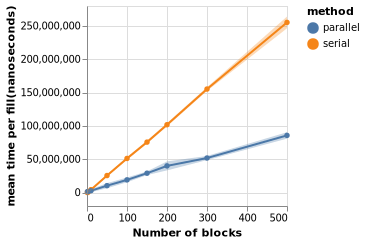

In [25]:
using DataFrames, VegaLite
times = DataFrame()
for (n, strial, ptrial) in zip(Ns, serial, parallel)
    times = vcat(
        times,        
        DataFrame(
            n=repeat([n], length(strial.times) + length(ptrial.times)),
            method=vcat(
                repeat([:serial], length(strial.times)),
                repeat([:parallel], length(ptrial.times))
            ),
            time=vcat(strial.times, ptrial.times)
        )
    )
end
@save "7procs" times serial parallel
times |>
    @vlplot(
        x={:n, title="Number of blocks", type=:quantitative},
        color={:method, type=:nominal}
    ) +
    @vlplot(mark={:line, point=:true}, y="mean(time)") +
    @vlplot(
        mark={:errorband, extent=:stdev},
        y={
            :time,
            title="mean time per fill(nanoseconds)",
            type=:quantitative
        }
    )
    

The results are rather encouraging. The behavior of both serial and parallel
versions are linear with the number of non-zero blocks, and hence with the
number of non-zero numbers entries in the matrix. This is what we hopped for.
And the parallel version is faster.

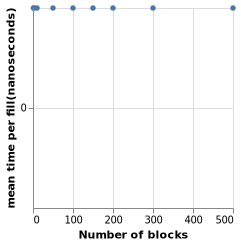

In [31]:
times |>
    @vlplot(
        x={:n, title="Number of blocks", type=:quantitative},
        transform=[
            {calculate="datum.parallel / datum.serial", as="speedup"}
        ]
    ) +
    @vlplot(mark={:line, point=:true}, y="mean(speedup)") +
    @vlplot(
        mark={:errorband, extent=:stdev},
        y={
            :speedup,
            title="mean time per fill(nanoseconds)",
            type=:quantitative
        }
    )

Next we try to teach the shared block banded matrix to do matrix-vector
multiplications in parallel:


In [ ]:
@everywhere begin
    function multiply!(
        out::SharedArray{T, 1},
        A::SharedBandedBlockBandedMatrix{T},
        x::SharedArray{T, 1}
    ) where T
        @sync begin
            for (p, proc) in enumerate(procs(A.data.blocks))
                @async remotecall_wait(multiply!, out, A, x, p)
            end
        end
        A
    end

    """Populates the blocks of A that are assigned to process p."""
    function multiply!(
        out::SharedArray{T, 1},
        A::SharedBandedBlockBandedMatrix{T},
        x::SharedArray{T, 1},
        p
    ) where T
        l, u = blockbandwidths(A)
        λ, μ = subblockbandwidths(A)
        N, M = nblocks(A)

        n = sum(
            min(i + A.u, nblocks(A, 2)) -  max(i - A.l, 1) + 1
            for i in 1:nblocks(A, 1)
        )
        m = length(procs(A.data.blocks))
        start = (n ÷ m) * (p - 1) + min((n % m), p - 1)
        stop = (n ÷ m) * p + min((n % m), p)
        k = 0
        for i in 1:nblocks(A, 1), j in max(i - A.l, 1):min(i + A.u, nblocks(A, 2))
            if k >= stop
                break
            elseif k >= start
                Ablock = view(A, Block(i, j))
                BLAS.gbmv!(
                    'N', N, λ, μ, one(T),
                    Ablock,
                    view(x),
                    one(T),
                    view(c)
                )
            end
            k += 1
        end
        A
    end
end